# Reinforcement Learning with Gymnasium

This notebook uses the Gymnasium library to explore basic reinforcement learning concepts in two classic environments: Blackjack and CartPole. The goal is to design simple policies, run thousands of simulated episodes, and empirically evaluate how different decision rules affect performance.


<Name\>
<Class\>
<Date\>





In [1]:
import gymnasium as gym
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython import display

## Random policy in Blackjack

I start with a baseline **random policy** in the `Blackjack-v1` environment. In each episode, the agent draws cards and chooses actions (`hit` or `stick`) uniformly at random until the game terminates.

The function `random_blackjack(n)` runs `n` episodes, tracks how many games the player wins, and returns the empirical win rate. This provides a noisy but informative baseline for how often a completely unprincipled strategy succeeds.


In [ ]:

def random_blackjack(n):
    """ Play a random game of Blackjack. Determine the percentage 
        the player wins out of n times.
    Parameters:
        n (int): number of episodes
    Returns:
        percent (float): percentage that the player wins
    """
    # Initialize the environment
    env = gym.make('Blackjack-v1')
    
    # Number of games won
    wins = 0
    # Number of games played
    games = 0

    # Begin game loop
    while games < n:

        # Initialize a new game
        obs, info = env.reset()
        terminated = False
        truncated = False

        # Take action if game not over
        while not (terminated or truncated):
            random_action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(random_action)

        # Update wins
        if reward == 1.0:
            wins += 1

        # Update game count
        games += 1

    env.close()

    # Return percentage of wins
    return (wins / n) * 100

        




In [3]:
# Run the game here
print(random_blackjack(50000))

28.398


## Threshold policy and win rates

Next, I replace the random strategy with a simple **threshold policy**: the player continues to hit as long as their current hand value is at most \(n\), and sticks otherwise.

The function `blackjack(n)` implements this rule and runs 10,000 episodes for a given threshold \(n\). By sweeping \(n = 1, 2, \dots, 21\) and plotting the resulting win percentages, the notebook identifies which thresholds lead to the best long-run performance and how sensitive the win rate is to this single policy parameter.


In [12]:
# Problem 2
def blackjack(n=11):
    """ Play blackjack with naive algorithm.
    Parameters:
        n (int): maximum accepted player hand
    Return:
        percent (float): percentage wins over 10_000 episodes
    """

    # Initialize the environment
    env = gym.make('Blackjack-v1')

    # Number of games won
    wins = 0
    # Number of games played
    games = 0

    # Begin game loop
    while games < 10000:

        # Initialize a new game
        obs, info = env.reset()
        terminated = False
        truncated = False

        # Take action if game not over
        while not (terminated or truncated):
            if obs[0] <= n:
                action = 1
            else:
                action = 0

            obs, reward, terminated, truncated, info = env.step(action)

        # Update wins
        if reward == 1.0:
            wins += 1

        # Update game count
        games += 1

    env.close()

    # Return percentage of wins
    return (wins / 10000) * 100
        


## Policy search over thresholds

To compare strategies, I evaluate the threshold policy for each $(n \in {1, \dots, 21})$ and store the corresponding win rates. These values are plotted with $n$ on the horizontal axis and win percentage on the vertical axis.

This experiment shows how even very simple policy classes can be tuned empirically: by running many episodes per setting, the Monte Carlo estimate of the win rate becomes stable enough to distinguish good thresholds from bad ones.


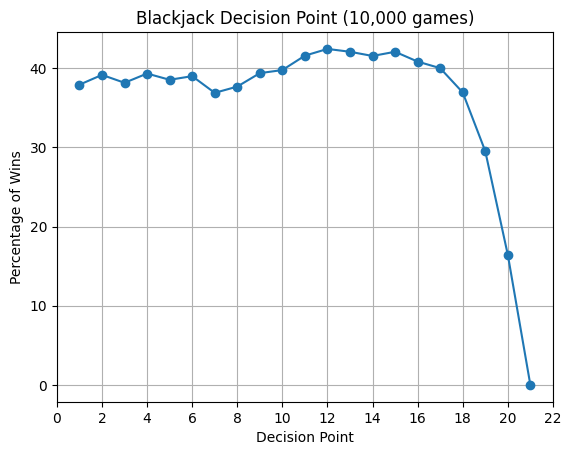

In [13]:

nums = [i for i in range(1, 22)]
wins = []

for n in nums:
    wins.append(blackjack(n))

plt.plot(nums, wins, marker='o')
plt.xticks(range(0, 23, 2))
plt.xlabel('Decision Point')
plt.ylabel('Percentage of Wins')   
plt.title('Blackjack Decision Point (10,000 games)')
plt.grid(True)

plt.savefig('blackjack.png')
plt.show()

    

## Heuristic control in CartPole

In the CartPole environment, the agent must apply left or right forces to keep a pole balanced on a moving cart. The observation vector includes the cart position and velocity, as well as the pole angle and angular velocity.

I implement a **hand-crafted heuristic policy** that chooses an action based primarily on the sign of the pole’s angular velocity. Starting from a random initial state, the agent repeatedly observes the state, selects an action using this rule, and steps the environment until the episode terminates or truncates. The function returns the total number of time steps the pole remains balanced.


In [ ]:

def cartpole(render=False):
    """ Solve CartPole-v1 by checking the velocity of the tip 
        of the pole.
    Parameters: 
        render (bool): If True, render environment at each step
    Return:
        iterations (integer): number of timesteps to solve the environment
    """
    if render:
        # Initialize the environment
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        # Initialize a new game
        obs, info = env.reset()
        img = plt.imshow(env.render())

    else:
        env = gym.make('CartPole-v1')
        # Initialize a new game
        obs, info = env.reset()

    terminated = False
    truncated = False

    # Number of iterations with pole vertical
    moves = 0

    # Begin game loop
    while not terminated and not truncated:
        # Take random action
        moves += 1
        # if obs[3] < -0.01:
        #     action = 0
        # if obs[3] > 0.01:
        #     action = 1
        # if obs[2] < 0:
        #     action = 0
        # else: 
        #     action = 1

        if obs[3] < 0:
            action = 0
        else:
            action = 1
        obs, reward, terminated, truncated, info = env.step(action)

        if render:
            # Update visualization
            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)

    env.close()

    return moves

201


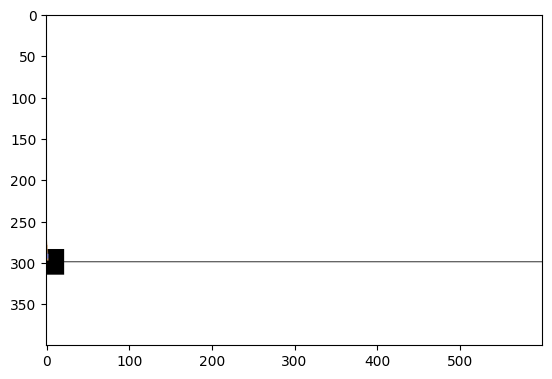

In [91]:
# Render the game and run once here
print(cartpole(True))

In [98]:
# Run the game here for 100 episodes and print average steps to termination
steps = 0
for _ in range(101):
    steps += cartpole(False)
print(steps/100)

204.48


## Evaluating CartPole performance

To assess the heuristic controller, I run multiple CartPole episodes and record the number of steps survived in each run. The distribution of episode lengths gives a direct measure of controller quality: longer episodes indicate better stabilization of the pole.

This small experiment illustrates the standard reinforcement learning workflow: define a policy, interact with an environment through repeated episodes, and use empirical returns (episode lengths or cumulative rewards) to quantify how successful the policy is.


In [ ]:

def car(render=False):
    """ Solve MountainCar-v0 by checking the position of the car.
    Parameters: 
        render (bool): If True, render environment at each step
    Return:
        iterations (integer): number of timesteps or time-periods to solve the environment
    """
    if render:
        # Initialize the environment
        env = gym.make('MountainCar-v0', render_mode='rgb_array')
        # Initialize a new game
        obs, info = env.reset()
        img = plt.imshow(env.render())

    else:
        env = gym.make('MountainCar-v0')
        # Initialize a new game
        obs, info = env.reset()

    terminated = False
    truncated = False

    # Number of iterations with pole vertical
    moves = 0

    # Begin game loop
    while not terminated and not truncated:
        # Take some action
        moves += 1

     
        if obs[0] < 0:
            if obs[0] > -1:
                action = 2
            if obs[1] >= 0:
                action = 2
            else:
                action = 0

        else:
            if obs[1] >= 0:
                action = 2
            else:
                action = 0


        
            
            
        obs, reward, terminated, truncated, info = env.step(action)

        if render:
            # Update visualization
            img.set_data(env.render())
            display.display(plt.gcf())
            display.clear_output(wait=True)

    env.close()

    return moves

117


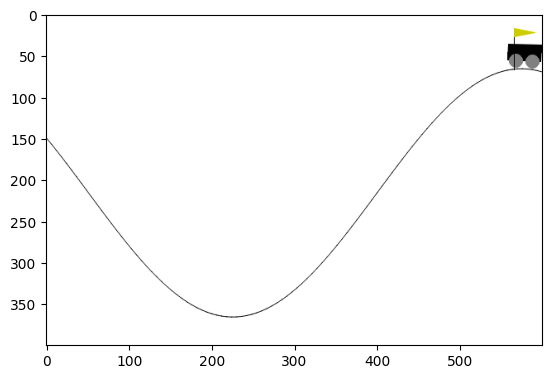

In [180]:
# Render the game here
print(car(True))

In [177]:
# Run the game here for 100 episodes and print average steps to termination
steps = 0
for _ in range(101):
    steps += car(False)
print(steps/100)

120.27


In [132]:
def epsilon_decay(episode, N, epsilon_start=1.0, epsilon_end=1e-6):
    """ Decay epsilon value over time according to a linear decay.
    Parameters:
        episode (int): current episode number
        N (int): total number of episodes
        epsilon_start (float): starting epsilon value
        epsilon_end (float): ending epsilon value
    Returns:
        epsilon (float): decayed epsilon value
    """
    delta = (epsilon_start - epsilon_end) / N
    return epsilon_start - (episode - 1) * delta
    
    

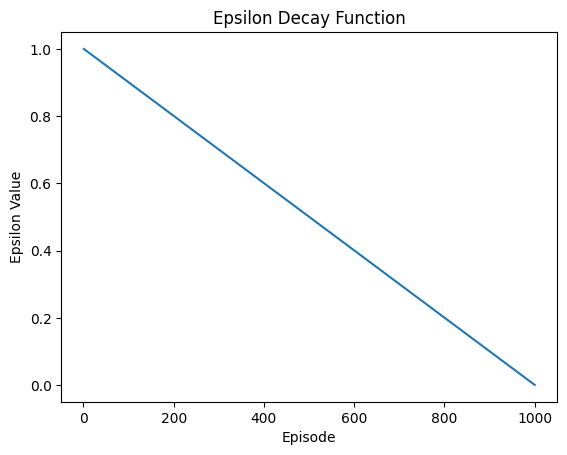

In [133]:
# Test with N = 1000
episodes = [i for i in range(1, 1001)]
epsilons = [epsilon_decay(i, 1000) for i in episodes]

plt.plot(episodes, epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')   
plt.title('Epsilon Decay Function')

plt.savefig('epsilon.png')
plt.show()

## Helper Function (Q-learning algorithm)

In [181]:
def qlearn(env, alpha=.1, gamma=.6, epsilon=.1, N=70_000, decay=False):
    """ Use the Q-learning algorithm to find qvalues.
    Parameters:
        env (str): environment name (i.e. gym environment name)
        alpha (float): learning rate
        gamma (float): discount factor
        epsilon (float): epsilon value for epsilon-greedy algo
        N (int): number of episodes to train for
        decay (bool): whether to decay epsilon according to epsilon_decay
    Returns:
        q_table (ndarray nxm): the Q(s,a) approximation values generated by Q-learning`
    """
    
    # Make environment
    env = gym.make(env)  
    # Make Q-table
    q_table = np.zeros((env.observation_space.n, env.action_space.n))

    # Train for N episodes
    for i in range(1,N+1):
    
        # Reset state and get initial state; Initialize penalties, reward, and done
        curr_state, info = env.reset() 
        penalties, reward, = 0,0
        done = False
        
        # Get epsilon value
        if not decay:
            curr_epsilon = epsilon
        else:
            curr_epsilon = epsilon_decay(i, N)
            
        # Keep going until the terminal state is reached
        while not done:
            
            # Employ the epsilon=greedy algorithm
            if random.uniform(0,1) < curr_epsilon: # Explore
                curr_action = env.action_space.sample()
            else:                                  # Exploit
                curr_action = np.argmax(q_table[curr_state])

            # Take action and get new state and reward
            next_state, reward, done, truncated, info = env.step(curr_action)

            # Calculate new qvalue
            old_value = q_table[curr_state,curr_action]
            next_max = (q_table[next_state]).max()
            new_value = (1-alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[curr_state, curr_action] = new_value

            # Check if penalty is made; specific to Taxi env
            if reward == -10:
                penalties += 1

            # Get next observation
            curr_state = next_state

        # Print episode number
        if i % 100 == 0:
            display.clear_output(wait=True)
            print("Training model...")
            print(f"Episode: {i}")

    env.close()
    print("Training finished.")
    return q_table, penalties

In [ ]:
# Random actions Taxi game
# Initialize the environment
env = gym.make("Taxi-v3")

# Number of games won
tot_reward = 0

# Initialize a new game
obs, info = env.reset()
terminated = False
truncated = False

# Take action if game not over
while not (terminated or truncated):
    random_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(random_action)
    tot_reward += reward

env.close()

# print reward
print(tot_reward)

-776


In [239]:
# Create Q-table for constant epsilon
q_table, penalties = qlearn("Taxi-v3")
# print(q_table)



Training model...
Episode: 70000
Training finished.


10


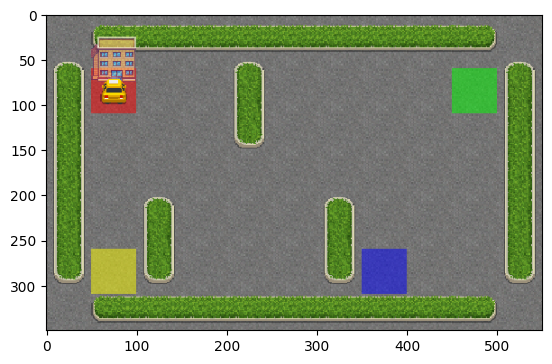

In [200]:
# Run the Taxi game here for Q-table with constant epsilon
# Initialize the environment
env = gym.make('Taxi-v3', render_mode='rgb_array')
# Initialize a new game
obs, info = env.reset()
img = plt.imshow(env.render())

# Number of games won
tot_reward = 0

# Initialize a new game
obs, info = env.reset()
terminated = False
truncated = False

# Take action if game not over
while not (terminated or truncated):
    # Pick action from Q Table
    action = np.argmax(q_table[obs, :])
    obs, reward, terminated, truncated, info = env.step(action)

    # rendering
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    tot_reward += reward

env.close()
print(tot_reward)


In [238]:
# Create Q-table for decaying epsilon
q_table_decay, penalties_decay = qlearn("Taxi-v3", decay=True)




Training model...
Episode: 70000
Training finished.


5


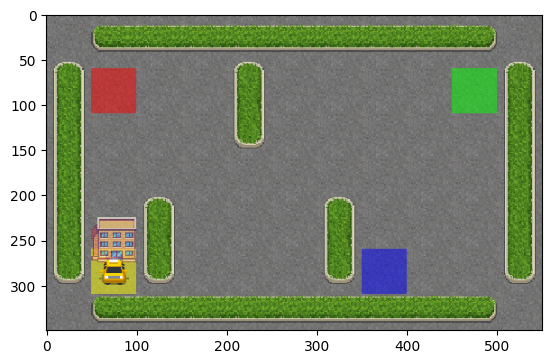

In [225]:
# Run the Taxi game here for Q-table with decaying epsilon

# Initialize the environment
env = gym.make('Taxi-v3', render_mode='rgb_array')
# Initialize a new game
obs, info = env.reset()
img = plt.imshow(env.render())

# Number of games won
tot_reward = 0

# Initialize a new game
obs, info = env.reset()
terminated = False
truncated = False

# Take action if game not over
while not (terminated or truncated):
    # Pick action from Q Table
    action = np.argmax(q_table_decay[obs, :])
    obs, reward, terminated, truncated, info = env.step(action)

    # rendering
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    tot_reward += reward

env.close()
print(tot_reward)

In [ ]:
def taxi(q_table, q_table_decay):
    """  Compare the Q-learning algorithm with a constant epsilon value to the one trained using a 
    decaying epsilon value.
    
    Parameters:
        q_table (ndarray nxm): table of qvalues that used constant epsilon
        q_table_decay (ndarray nxm): table of qvalues that used a decaying epsilon
    Returns:
        constant_reward (float): mean reward of 1000 episodes of Q-learning algorithm using constant epsilon
        decay_reward (float): mean reward of 1000 episodes of Q-learning algorithm using decayed epsilon
    """
    ### DECAY ###
    decay = 0
    
    for _ in range(1000):
        env = gym.make('Taxi-v3')
        # Initialize a new game
        obs, info = env.reset()

        # Number of games won
        tot_reward_decay = 0

        # Initialize a new game
        obs, info = env.reset()
        terminated = False
        truncated = False

        # Take action if game not over
        while not (terminated or truncated):
            # Pick action from Q Table
            action = np.argmax(q_table_decay[obs, :])
            obs, reward, terminated, truncated, info = env.step(action)
            tot_reward_decay += reward

        decay += tot_reward_decay

        env.close()

    ### NON DECAY ###
    non_decay = 0

    for _ in range(1000):
        env = gym.make('Taxi-v3')
        # Initialize a new game
        obs, info = env.reset()

        # Number of games won
        tot_reward = 0

        # Initialize a new game
        obs, info = env.reset()
        terminated = False
        truncated = False

        # Take action if game not over
        while not (terminated or truncated):
            # Pick action from Q Table
            action = np.argmax(q_table[obs, :])
            obs, reward, terminated, truncated, info = env.step(action)
            tot_reward += reward
            
        non_decay += tot_reward

        env.close()

    env.close()

    return non_decay / 1000, decay / 1000



In [241]:
print(taxi(q_table, q_table_decay))
print(f'Non decay penalties {penalties}, Decay penalties {penalties_decay}')


(7.96, 7.996)
Non decay penalties 0, Decay penalties 0


### Analysis of constant epsilon and decaying epsilon Q-tables here

Allowing epsilon to decay seemed to help marginally if at all for the trials I ran. This makes sense as the result is likely going to be similar in such a simple environment. If the environment was more complex (with more states or parameters) it would be beneficial to explore more as the naive solution might not always be the best and the non decay qlearn is more likely to return somethign closer to the naive solution. The biggest tradeoff is in complexity. The decay qlearn took significantly longer to process and 'learn'. Each episode for non decay ran in constant time however for the decaying function the first episodes took much longer because there was more exploring going on and the last ones were drastically more quick. 